# Solar Energy Data Loading and Overview

This notebook demonstrates how to load and get an overview of solar energy data using the hybrid CSV/API approach.

**Key Features:**
- Load historical CSV data (2+ years of 15-minute intervals)
- Load recent API data for up-to-date information
- Combine data sources intelligently
- Basic data validation and statistics

In [1]:
# Import libraries
import sys
sys.path.append('../src')

from core.data_manager import SolarDataManager
from core.enphase_client import EnphaseClient
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

print("📊 Solar Energy Data Analysis - Data Loading & Overview")
print("=" * 60)

📊 Solar Energy Data Analysis - Data Loading & Overview


/Users/christopherhaught/projects/power-usage-and-consumption/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 1. Initialize Hybrid Data Manager

We'll use the SolarDataManager which combines CSV historical data with live API updates.

In [2]:
# Initialize data manager using smart data source detection
from core.data_source_detector import DataSourceDetector
from core.location_loader import create_notebook_location

# Initialize location from .env (with fallback to Denver)
location = create_notebook_location()
print(f"🌍 Location configured: {location.location_name}")
print(f"📍 Coordinates: {location.latitude:.3f}°N, {location.longitude:.3f}°W")

# Initialize the smart data source detector
detector = DataSourceDetector(location=location)

# Determine the optimal data loading strategy
strategy = detector.determine_data_strategy()

# Initialize data manager with the detected strategy
data_manager = SolarDataManager(
    csv_path=strategy['csv_path'], 
    enphase_client=strategy['client'],
    cache_dir="../data/processed"
)

print("✅ Data manager initialized with location-aware configuration")

🌍 Location configured: Holly Springs, NC
📍 Coordinates: 35.668°N, -78.850°W
📊 Determining Best Data Source...
✅ Using REAL Enphase API credentials!
   📈 Will attempt to fetch live data from your solar system
   🎯 PRIORITY: Real Enphase API data from your solar system
   📡 Will attempt live API data first
   📁 CSV fallback: ../data/raw/4136754_custom_report.csv

📋 Available Data Sources (in priority order):
   🎯 SELECTED: 📈 REAL CSV DATA - Real solar panel CSV data through 2025
      Available: 🎭 SYNTHETIC/MOCK DATA - Synthetic data for Holly Springs, NC (ends June 2024)
      Available: 🎭 GENERIC MOCK DATA - Generic synthetic data (ends March 2024)
✅ Data manager initialized with location-aware configuration


## 2. Load and Examine CSV Data

In [3]:
# Load CSV data using smart data source detection
csv_data = data_manager.load_csv_data()

# Get comprehensive data summary and recency analysis
data_summary = data_manager.get_data_summary()
recency_info = detector.analyze_data_recency(csv_data, data_summary)

# Generate comprehensive data source report
detector.generate_final_report(strategy, data_summary, recency_info)

print(f"\nDataset shape: {csv_data.shape}")
print(f"Columns: {list(csv_data.columns)}")
print(f"Date range: {csv_data.index.min()} to {csv_data.index.max()}")
print(f"Data granularity: {csv_data.attrs.get('granularity', 'unknown')}")
print(f"Total records: {len(csv_data):,}")

# Display first few rows
print("\n=== First 5 rows ===")
print(csv_data.head())

# Check for missing data
print("\n=== Missing values ===")
print(csv_data.isnull().sum())

INFO:core.data_manager:Loading CSV data from ../data/raw/4136754_custom_report.csv
INFO:core.data_manager:Loaded 70272 CSV records from 2023-09-16 00:00:00 to 2025-09-16 23:45:00
INFO:core.data_manager:Loading API data for last 30 days


Error getting lifetime energy: 401

📈 Solar Data Loaded Successfully:
   🎯 DATA TYPE: 📈 REAL API DATA (with CSV fallback)
   📡 Source: 📁 CSV DATA
   📁 Source: CSV file (API failed, using fallback)
   📊 CSV Records: 70,272
   📅 CSV Date range: 2023-09-16 to 2025-09-16
   📅 Data recency: ✅ RECENT (7 days old)
   🕐 Latest data point: 2025-09-16

✅ SUCCESS: Using REAL solar production data!
   📈 Authentic solar panel data (not synthetic)
   📊 Contains data through 2025
   ℹ️ Note: API returned 401 (expired token), but CSV data is recent

Dataset shape: (70272, 4)
Columns: ['Production (kWh)', 'Consumption (kWh)', 'Export (kWh)', 'Import (kWh)']
Date range: 2023-09-16 00:00:00 to 2025-09-16 23:45:00
Data granularity: 15min
Total records: 70,272

=== First 5 rows ===
                     Production (kWh)  Consumption (kWh)  Export (kWh)  \
Date/Time                                                                
2023-09-16 00:00:00               0.0              0.110           0.0   
2023-0

## 3. Basic Statistics and Data Quality

In [4]:
# Basic statistics
print("=== DATA QUALITY SUMMARY ===")
print(f"Data spans {(csv_data.index.max() - csv_data.index.min()).days} days")
print(f"Expected 15-min intervals: {(csv_data.index.max() - csv_data.index.min()).days * 96:,}")
print(f"Actual intervals: {len(csv_data):,}")
print(f"Data completeness: {len(csv_data) / ((csv_data.index.max() - csv_data.index.min()).days * 96) * 100:.1f}%")

# Statistical summary
print("\n=== STATISTICAL SUMMARY ===")
print(csv_data.describe())

=== DATA QUALITY SUMMARY ===
Data spans 731 days
Expected 15-min intervals: 70,176
Actual intervals: 70,272
Data completeness: 100.1%

=== STATISTICAL SUMMARY ===
       Production (kWh)  Consumption (kWh)  Export (kWh)  Import (kWh)
count       70272.00000       70272.000000  70272.000000  70272.000000
mean            0.38989           0.374809      0.256440      0.241360
std             0.61609           0.509354      0.500361      0.469741
min             0.00000           0.000000      0.000000      0.000000
25%             0.00000           0.112000      0.000000      0.000000
50%             0.00200           0.180000      0.000000      0.099000
75%             0.57425           0.409000      0.196000      0.245000
max             1.91800           5.364000      1.857000      5.119000


## 4. Create Daily Summary Data

In [5]:
# Get daily production data using hybrid approach
daily_data = data_manager.get_daily_production(source_priority="csv_first")

print(f"Daily data shape: {daily_data.shape}")
print(f"Date range: {daily_data.index.min().date()} to {daily_data.index.max().date()}")

# Basic daily statistics
print("\n=== DAILY PRODUCTION SUMMARY ===")
print(f"Average daily production: {daily_data['Production (kWh)'].mean():.1f} kWh")
print(f"Peak daily production: {daily_data['Production (kWh)'].max():.1f} kWh")
print(f"Minimum daily production: {daily_data['Production (kWh)'].min():.1f} kWh")
print(f"Total production over period: {daily_data['Production (kWh)'].sum():,.0f} kWh")

if 'Consumption (kWh)' in daily_data.columns:
    print(f"\nAverage daily consumption: {daily_data['Consumption (kWh)'].mean():.1f} kWh")
    net_energy = daily_data['Production (kWh)'] - daily_data['Consumption (kWh)']
    surplus_days = (net_energy > 0).sum()
    print(f"Days with energy surplus: {surplus_days} out of {len(daily_data)} ({surplus_days/len(daily_data)*100:.1f}%)")

Daily data shape: (732, 4)
Date range: 2023-09-16 to 2025-09-16

=== DAILY PRODUCTION SUMMARY ===
Average daily production: 37.4 kWh
Peak daily production: 61.3 kWh
Minimum daily production: 0.6 kWh
Total production over period: 27,398 kWh

Average daily consumption: 36.0 kWh
Days with energy surplus: 404 out of 732 (55.2%)


## 5. Quick Data Visualization

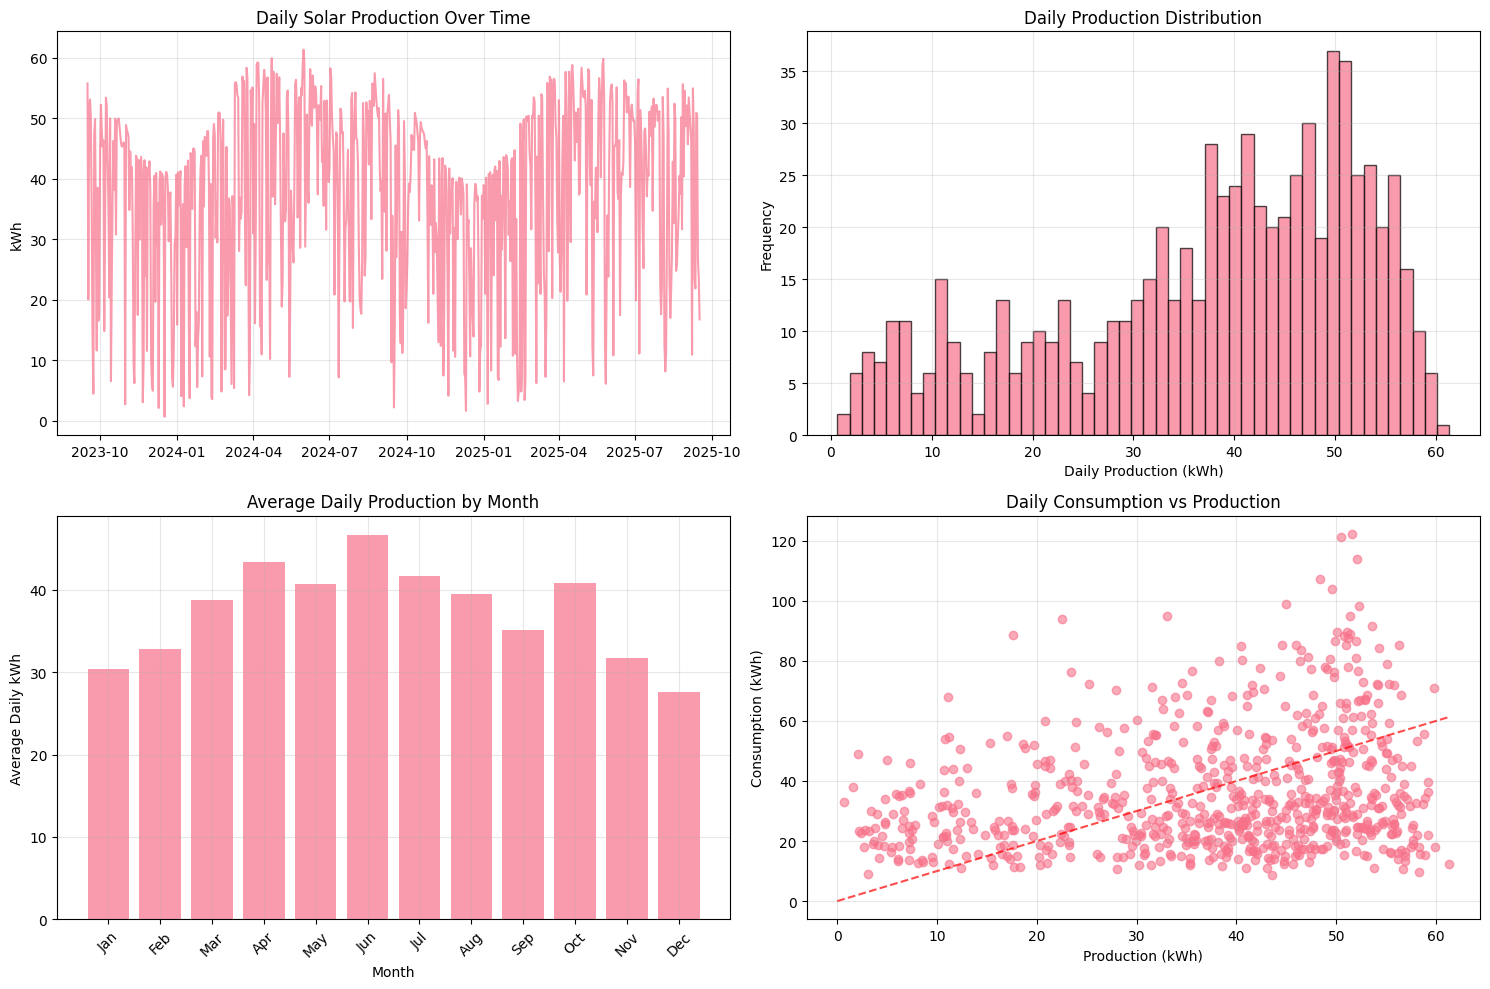

In [6]:
# Create overview plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Daily production over time
axes[0,0].plot(daily_data.index, daily_data['Production (kWh)'], alpha=0.7)
axes[0,0].set_title('Daily Solar Production Over Time')
axes[0,0].set_ylabel('kWh')
axes[0,0].grid(True, alpha=0.3)

# Production distribution
axes[0,1].hist(daily_data['Production (kWh)'], bins=50, alpha=0.7, edgecolor='black')
axes[0,1].set_title('Daily Production Distribution')
axes[0,1].set_xlabel('Daily Production (kWh)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].grid(True, alpha=0.3)

# Monthly averages
monthly_avg = daily_data.groupby(daily_data.index.month)['Production (kWh)'].mean()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[1,0].bar(range(1, len(monthly_avg)+1), monthly_avg.values, alpha=0.7)
axes[1,0].set_title('Average Daily Production by Month')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Average Daily kWh')
axes[1,0].set_xticks(range(1, len(monthly_avg)+1))
axes[1,0].set_xticklabels([month_names[i-1] for i in monthly_avg.index], rotation=45)
axes[1,0].grid(True, alpha=0.3)

# Consumption vs Production (if available)
if 'Consumption (kWh)' in daily_data.columns:
    axes[1,1].scatter(daily_data['Production (kWh)'], daily_data['Consumption (kWh)'], alpha=0.6)
    axes[1,1].plot([0, daily_data['Production (kWh)'].max()], [0, daily_data['Production (kWh)'].max()], 'r--', alpha=0.7)
    axes[1,1].set_title('Daily Consumption vs Production')
    axes[1,1].set_xlabel('Production (kWh)')
    axes[1,1].set_ylabel('Consumption (kWh)')
    axes[1,1].grid(True, alpha=0.3)
else:
    # Rolling 30-day average
    rolling_avg = daily_data['Production (kWh)'].rolling(30).mean()
    axes[1,1].plot(daily_data.index, daily_data['Production (kWh)'], alpha=0.3, label='Daily')
    axes[1,1].plot(rolling_avg.index, rolling_avg.values, linewidth=2, label='30-day average')
    axes[1,1].set_title('Production with 30-day Rolling Average')
    axes[1,1].set_ylabel('kWh')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Data Source Summary

In [7]:
# Get data source summary
summary = data_manager.get_data_summary()

print("=== DATA SOURCES SUMMARY ===")
print(f"\n📁 CSV Data:")
print(f"  Available: {summary['csv']['available']}")
print(f"  Records: {summary['csv']['records']:,}")
print(f"  Date range: {summary['csv']['date_range']}")
print(f"  Granularity: {summary['csv']['granularity']}")

print(f"\n🌐 API Data:")
print(f"  Client type: {'Mock (demo mode)' if summary['api']['is_mock'] else 'Real Enphase API'}")
print(f"  Available: {summary['api']['available']}")
print(f"  Records: {summary['api']['records']:,}")
print(f"  Date range: {summary['api']['date_range']}")
print(f"  Granularity: {summary['api']['granularity']}")

print("\n✅ Data loading and overview complete!")
print("\nNext steps:")
print("- Run 01b_seasonal_and_temporal_analysis.ipynb for detailed time series analysis")
print("- Run 01c_baseline_ml_models.ipynb for machine learning models")

=== DATA SOURCES SUMMARY ===

📁 CSV Data:
  Available: True
  Records: 70,272
  Date range: ('2023-09-16', '2025-09-16')
  Granularity: 15min

🌐 API Data:
  Client type: Real Enphase API
  Available: False
  Records: 0
  Date range: None
  Granularity: None

✅ Data loading and overview complete!

Next steps:
- Run 01b_seasonal_and_temporal_analysis.ipynb for detailed time series analysis
- Run 01c_baseline_ml_models.ipynb for machine learning models
